In [25]:
from getpass import getpass
import urllib
import os
from random import sample
from glob import glob
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral, create_pairwise_gaussian

import datetime

In [40]:
#pred_path = "../../../project/masks/sresnet/marco_best"
test_path = "../../../project/test_images/test_images"
#mask_path = "../../../project/masks/sresnet/marco_best"
#test_path = "tmp_images"
mask_path = "tmp_images"

test_list = os.listdir(test_path)
test_list.sort()

mask_list = os.listdir(mask_path)
mask_list.sort()

print(test_list)

['test_10.png', 'test_105.png', 'test_106.png', 'test_107.png', 'test_108.png', 'test_11.png', 'test_115.png', 'test_116.png', 'test_12.png', 'test_121.png', 'test_122.png', 'test_123.png', 'test_124.png', 'test_128.png', 'test_129.png', 'test_130.png', 'test_131.png', 'test_136.png', 'test_137.png', 'test_138.png', 'test_139.png', 'test_14.png', 'test_140.png', 'test_142.png', 'test_143.png', 'test_144.png', 'test_145.png', 'test_15.png', 'test_151.png', 'test_152.png', 'test_153.png', 'test_154.png', 'test_155.png', 'test_157.png', 'test_159.png', 'test_161.png', 'test_162.png', 'test_168.png', 'test_169.png', 'test_170.png', 'test_174.png', 'test_175.png', 'test_176.png', 'test_177.png', 'test_186.png', 'test_187.png', 'test_189.png', 'test_190.png', 'test_191.png', 'test_192.png', 'test_196.png', 'test_200.png', 'test_201.png', 'test_202.png', 'test_204.png', 'test_205.png', 'test_206.png', 'test_207.png', 'test_208.png', 'test_21.png', 'test_211.png', 'test_215.png', 'test_216.png

(608, 608, 3)


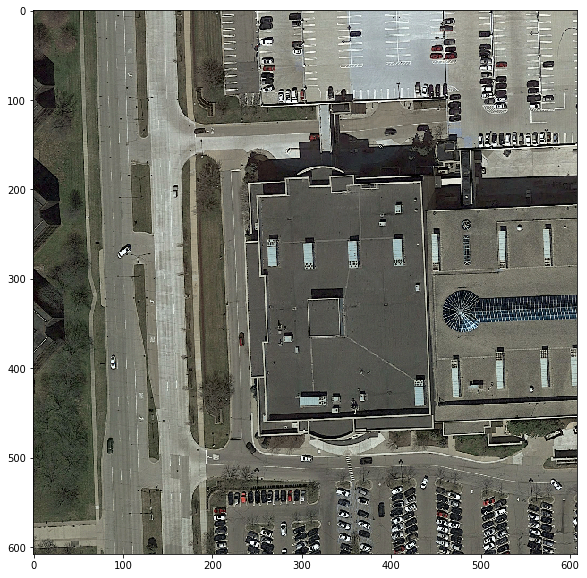

In [41]:
plt.figure(figsize=(10, 10))

image_name = test_list[0]
#image_name = "im1.ppm"

image = np.array(Image.open(os.path.join(test_path, image_name)))

IMAGE_SHAPE = np.shape(image)
print(IMAGE_SHAPE)

img = image.copy()

plt.imshow(img)
plt.show()


(240, 320, 3)


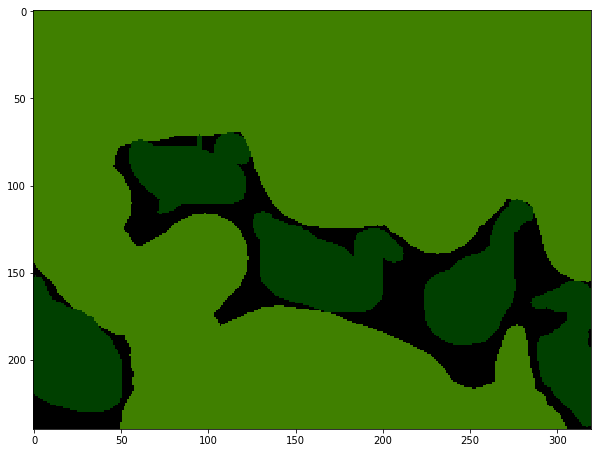

In [30]:
plt.figure(figsize=(10, 10))

mask_name = mask_list[0]

mask = np.array(Image.open(os.path.join(mask_path, mask_name)))

print(np.shape(mask))
#print(mask[0])

plt.imshow(mask)
plt.show()



In [35]:
fn_anno = os.path.join(mask_path, "anno1.ppm")

# Convert the annotation's RGB color to a single 32-bit integer color 0xBBGGRR
anno_rgb = np.array(Image.open(fn_anno)).astype(np.uint32)
anno_lbl = anno_rgb[:,:,0] + (anno_rgb[:,:,1] << 8) + (anno_rgb[:,:,2] << 16)

# Convert the 32bit integer color to 1, 2, ... labels.
# Note that all-black, i.e. the value 0 for background will stay 0.
colors, labels = np.unique(anno_lbl, return_inverse=True)

[    0 16384 32832]
[2 2 2 ... 0 0 0]


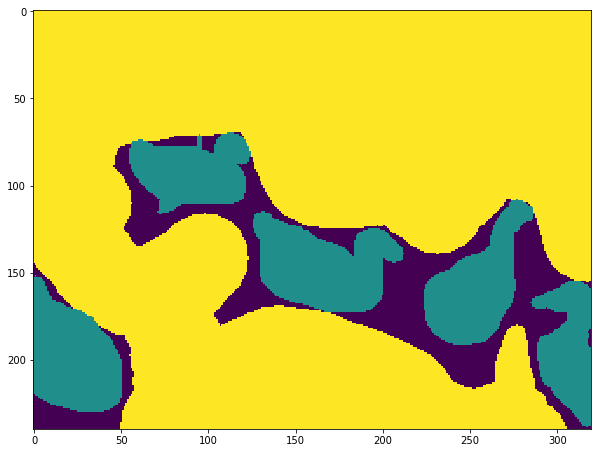

In [38]:
print(colors)
print(labels)

plt.figure(figsize=(10, 10))
plt.imshow(anno_lbl)
plt.show()


In [39]:
# But remove the all-0 black, that won't exist in the MAP!
HAS_UNK = 0 in colors
if HAS_UNK:
    print("Found a full-black pixel in annotation image, assuming it means 'unknown' label, and will thus not be present in the output!")
    print("If 0 is an actual label for you, consider writing your own code, or simply giving your labels only non-zero values.")
    colors = colors[1:]
#else:
#    print("No single full-black pixel found in annotation image. Assuming there's no 'unknown' label!")

# And create a mapping back from the labels to 32bit integer colors.
colorize = np.empty((len(colors), 3), np.uint8)
colorize[:,0] = (colors & 0x0000FF)
colorize[:,1] = (colors & 0x00FF00) >> 8
colorize[:,2] = (colors & 0xFF0000) >> 16

# Compute the number of classes in the label image.
# We subtract one because the number shouldn't include the value 0 which stands
# for "unknown" or "unsure".
n_labels = len(set(labels.flat)) - int(HAS_UNK)
print(n_labels, " labels", (" plus \"unknown\" 0: " if HAS_UNK else ""), set(labels.flat))

Found a full-black pixel in annotation image, assuming it means 'unknown' label, and will thus not be present in the output!
If 0 is an actual label for you, consider writing your own code, or simply giving your labels only non-zero values.
2  labels  plus "unknown" 0:  {0, 1, 2}


In [ ]:
    # Example using the DenseCRF2D code
    d = dcrf.DenseCRF2D(img.shape[1], img.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=HAS_UNK)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=img,
                           compat=10,
                           kernel=dcrf.DIAG_KERNEL,
                           normalization=dcrf.NORMALIZE_SYMMETRIC)

In [ ]:
# Run five inference steps.
Q = d.inference(5)

# Find out the most probable class for each pixel.
MAP = np.argmax(Q, axis=0)

# Convert the MAP (labels) back to the corresponding colors and save the image.
# Note that there is no "unknown" here anymore, no matter what we had at first.
MAP = colorize[MAP,:]
imwrite(fn_output, MAP.reshape(img.shape))

# Just randomly manually run inference iterations
Q, tmp1, tmp2 = d.startInference()
for i in range(5):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d.stepInference(Q, tmp1, tmp2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


64
255.0


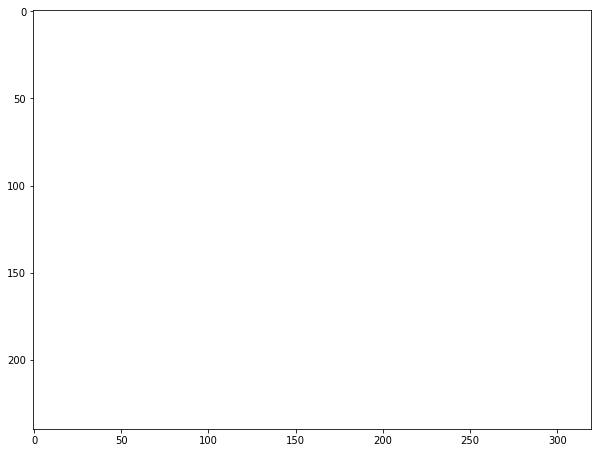

In [31]:
from scipy.ndimage import gaussian_filter

mask_conved = gaussian_filter(mask,sigma=20)

print(np.max(mask_conved))

mask_conved = mask_conved * 255.0 / np.max(mask_conved)

print(np.max(mask_conved))

plt.figure(figsize=(10, 10))
plt.imshow(mask_conved)
plt.show()

In [32]:
#prob_map = mask_conved / 255.0
prob_map = mask/255.0


In [33]:
#prob_map = prob_map * 0.0 
#prob_map = 1 - prob_map

USE_SOFTMAX = 1
prob_fb = np.tile(prob_map[np.newaxis,:,:],(2,1,1))
if USE_SOFTMAX==1:
    prob_fb[1,:,:] = 1 - prob_fb[0,:,:]
elif USE_SOFTMAX==2:
    print(' ')
elif USE_SOFTMAX==3:
    prob_fb[0,:,:] = 1 - prob_fb[0,:,:]
    
print(np.shape(prob_fb))
#print(prob_fb[0][0])
tmp = prob_fb.flatten()
tmp = np.sort(tmp)
print(tmp[:10])
print(tmp[np.argmax(tmp>0.0)])

pmin = tmp[np.argmax(tmp>0.0)]

prob_fb = (prob_fb+pmin)/(1+pmin)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [22]:
n_labels = 2

processed_prob_fb = -np.log(prob_fb)

U = unary_from_softmax(processed_prob_fb)
d = dcrf.DenseCRF2D(img.shape[1], img.shape[0], n_labels)
d.setUnaryEnergy(U)

d.addPairwiseGaussian(sxy=(1, 1), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

d.addPairwiseBilateral(sxy=(10, 10), srgb=(100, 100, 100), rgbim=img,
                       compat=10,
                       kernel=dcrf.DIAG_KERNEL,
                       normalization=dcrf.NORMALIZE_SYMMETRIC)

"""
# This adds the color-independent term, features are the locations only.
d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

# This adds the color-dependent term, i.e. features are (x,y,r,g,b).
d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=img,
                       compat=10,
                       kernel=dcrf.DIAG_KERNEL,
                       normalization=dcrf.NORMALIZE_SYMMETRIC)
"""


'\n# This adds the color-independent term, features are the locations only.\nd.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,\n                      normalization=dcrf.NORMALIZE_SYMMETRIC)\n\n# This adds the color-dependent term, i.e. features are (x,y,r,g,b).\nd.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=img,\n                       compat=10,\n                       kernel=dcrf.DIAG_KERNEL,\n                       normalization=dcrf.NORMALIZE_SYMMETRIC)\n'

Current Time GMT= 06/15/20 15:38:24


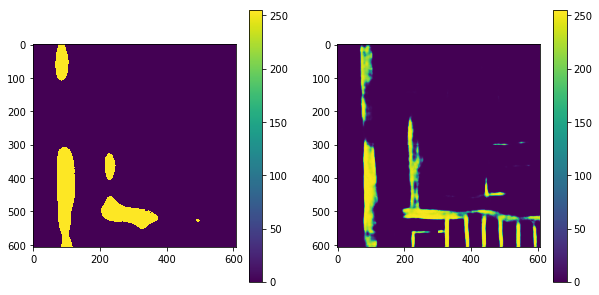

In [23]:


Q_unary = d.inference(1)
map_soln_unary = np.argmax(Q_unary, axis=0)
map_soln_unary = map_soln_unary.reshape((img.shape[1],img.shape[0]))

#print(map_soln_unary[0])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(map_soln_unary * 255.0); plt.colorbar();
plt.subplot(1,2,2); plt.imshow(mask); plt.colorbar();

now = datetime.datetime.now()

current_time = now.strftime("%D %H:%M:%S")
print("Current Time GMT=", current_time)

out = map_soln_unary.copy()
out8 = (((out - out.min()) / (out.max() - out.min())) * 255.9).astype(np.uint8)

out_img = Image.fromarray(out8)
out_img.save("file.png")

#map_soln_rescaled = map_soln_unary * 255.0
#map_soln_rescaled = map_soln_rescaled.astype(np.uint8)
#map_soln_save = Image.fromarray(map_soln_rescaled)
#if map_soln_save.mode != 'L':
#map_soln_save = map_soln_save.convert('L')
#map_soln_save.save('test4.png',compression=None)

#img_to_save = tf.keras.preprocessing.image.array_to_img(map_soln_unary * 255.0)
#img_to_save.save('test_img')

#print(map_soln_unary[0])

In [19]:
print(np.shape(map_soln_unary))
print(type(map_soln_unary))
import png
map_soln_unary = map_soln_unary.astype(np.uint8)
png.from_array(map_soln_unary,'L').save('test5.png')

(608, 608)
<class 'numpy.ndarray'>


In [29]:
output = map_soln_unary.copy()
output = output.astype(np.uint8)
output = np.expand_dims(output,axis=2)

#tf.keras.preprocessing.image.save_img('test11.png',output)

output_img = tf.keras.preprocessing.image.array_to_img(output)
output_img.save('test20.png')
#print(output_img.format)
#print(output_img.mode)
#print(output_img.size)

In [35]:
import scipy.misc
import imageio
imageio.imwrite('tmp_images/outfile.jpg', output)

In [11]:
image = np.expand_dims(image, 0)

print(np.shape(image))


(1, 416, 416, 3)


In [ ]:
#output = np.expand_dims(image, 0)
output = image.astype(np.uint8)
output = output.reshape((416,416,1))
output_img = tf.keras.preprocessing.image.array_to_img(output).resize((608, 608))

#prob_map = model.predict(image)[0]

#output = prob_map * 255.0

#output = output.astype(np.uint8)
#output_img = tf.keras.preprocessing.image.array_to_img(output).resize((608, 608))

print(np.shape(image))
#print(np.shape(img_parts))
#print(np.shape(output_img))

print(np.shape(output_img))
plt.imshow(output_img)
plt.show()

#print(output[0][0])
#print(output_img)
#print(np.shape(output))
#print(np.shape(output_img))

In [ ]:
prob_fb = np.tile(prob_map[np.newaxis,:,:],(2,1,1))
prob_fb[1,:,:] = 1 - prob_fb[0,:,:]


In [ ]:
prob_fg = np.expand_dims(prob_map,axis=0)
print(np.shape(prob_fg))

prob_bg = 1 - prob_fg
print(np.shape(prob_bg))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1); plt.imshow(prob_fg[0]); plt.title('Foreground probability'); plt.axis('off'); plt.colorbar();
plt.subplot(1,2,2); plt.imshow(prob_bg[0]); plt.title('Background probability'); plt.axis('off'); plt.colorbar();


In [ ]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

# Inference without pair-wise terms
U = unary_from_softmax(prob_fb)  # note: num classes is first dim
print(np.shape(U))
d = dcrf.DenseCRF2D(416, 416, 2)
d.setUnaryEnergy(U)

# Run inference for 10 iterations
Q_unary = d.inference(10)

# The Q is now the approximate posterior, we can get a MAP estimate using argmax.
map_soln_unary = np.argmax(Q_unary, axis=0)

# Unfortunately, the DenseCRF flattens everything, so get it back into picture form.
map_soln_unary = map_soln_unary.reshape((416,416))

# And let's have a look.
plt.imshow(map_soln_unary); plt.axis('off'); plt.title('MAP Solution without pairwise terms');

In [ ]:
print(map_soln_unary)

In [ ]:
print(U)

In [ ]:
print(np.shape(image))
print(np.shape((output_img)))
print(image)
print(prob_map)
print(np.shape(prob_map))

print(image_path)


In [ ]:
"""
from scipy.stats import multivariate_normal

H, W, NLABELS = 400, 512, 2

# This creates a gaussian blob...
pos = np.stack(np.mgrid[0:H, 0:W], axis=2)
rv = multivariate_normal([H//2, W//2], (H//4)*(W//4))
probs = rv.pdf(pos)

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

probs = np.tile(probs[np.newaxis,:,:],(2,1,1))
probs[1,:,:] = 1 - probs[0,:,:]


In [ ]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

prob_map = np.tile(prob_map[np.newaxis,:,:],(2,1,1))
prob_map[1,:,:] = 1 - prob_map[0,:,:]

print(np.shape(prob_map))

In [ ]:
print(np.shape(pos))
print(np.shape(probs))

In [ ]:
plt.figure()
plt.hist(prob_map.flatten(),bins=50)
plt.show()

In [ ]:
U = unary_from_softmax(prob_map)
print(np.shape(prob_map))
print(np.shape(U))

In [ ]:
U = unary_from_softmax(probs)
pairwise_energy = create_pairwise_bilateral(sdims=(10,10), schan=(0.01,), img=img, chdim=2)

W = 608
H = 608
NLABELS = 2
d = dcrf.DenseCRF2D(W, H, NLABELS)
d.setUnaryEnergy(U)
d.addPairwiseEnergy(pairwise_energy, compat=10)  # `compat` is the "strength" of this potential.


In [ ]:
plt.figure(figsize=(18, 18))
plt.imshow(tf.keras.preprocessing.image.array_to_img(output_img))
plt.axis('off')

plt.show()